In [799]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from multiprocessing import Pool
from tqdm.auto import tqdm
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa import arima_process
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)


sns.set_context("paper", font_scale=1.7)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
        "figure.facecolor": "#FAFAFA",
    },
)

In [19]:
ar = [1, -0.5]
ma = [1, ]
n = 1000
X = arima_process.arma_generate_sample(ar, ma, n)

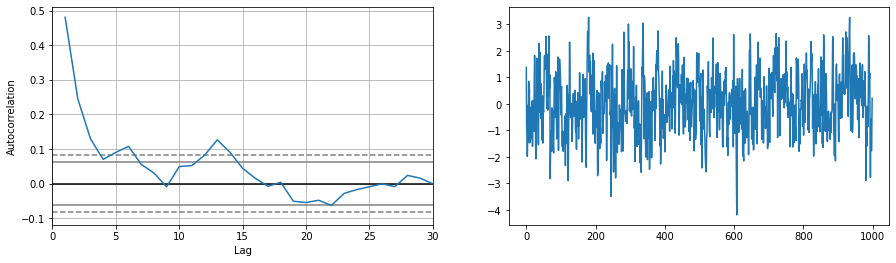

In [29]:
fig, axs = plt.subplots(figsize = (15,4), ncols = 2)
pd.plotting.autocorrelation_plot(X, ax = axs[0])
axs[0].set_xlim(0,30)

ax = axs[1]
ax.plot(X)

# Kalman Filter Test

In [30]:
from filterpy.kalman import KalmanFilter

In [32]:
f = KalmanFilter (dim_x=2, dim_z=1)

f.x = np.array([2., 0.])

In [33]:
f.F = np.array([[1.,1.],
                [0.,1.]])

In [34]:
f.H = np.array([[1.,0.]])

In [36]:
f.P = np.array([[1000.,    0.],
                [   0., 1000.] ])

In [38]:
f.R = np.array([[5.]])

In [39]:
from filterpy.common import Q_discrete_white_noise
f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13)

# SM

## Tutorial 

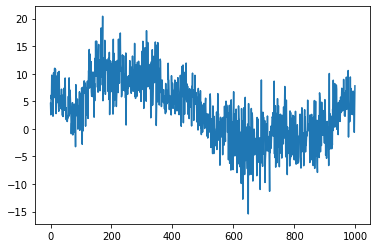

In [159]:
def gen_data_for_model1():
    nobs = 1000

    rs = np.random.RandomState(seed=93572)

    d = 5
    var_y = 5
    var_coeff_x = 0.01
    var_coeff_w = 0.5

    x_t = rs.uniform(size=nobs)
    w_t = rs.uniform(size=nobs)
    eps = rs.normal(scale=var_y**0.5, size=nobs)

    beta_x = np.cumsum(rs.normal(size=nobs, scale=var_coeff_x**0.5))
    beta_w = np.cumsum(rs.normal(size=nobs, scale=var_coeff_w**0.5))

    y_t = d + beta_x * x_t + beta_w * w_t + eps
    return y_t, x_t, w_t, beta_x, beta_w

y_t, x_t, w_t, beta_x, beta_w = gen_data_for_model1()
_ = plt.plot(y_t)

In [163]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 4)

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, 0.001, 0.001]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov'] = np.diag(params[2:4])


In [164]:
mod = TVRegression(y_t, x_t, w_t)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -2336.846
Date:                Sun, 08 Nov 2020   AIC                           4685.692
Time:                        16:37:50   BIC                           4715.139
Sample:                             0   HQIC                          4696.884
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.0548      0.202     25.050      0.000       4.659       5.450
var.e           5.1240      0.249     20.571      0.000       4.636       5.612
var.x.coeff     0.0468      0.022      2.097    

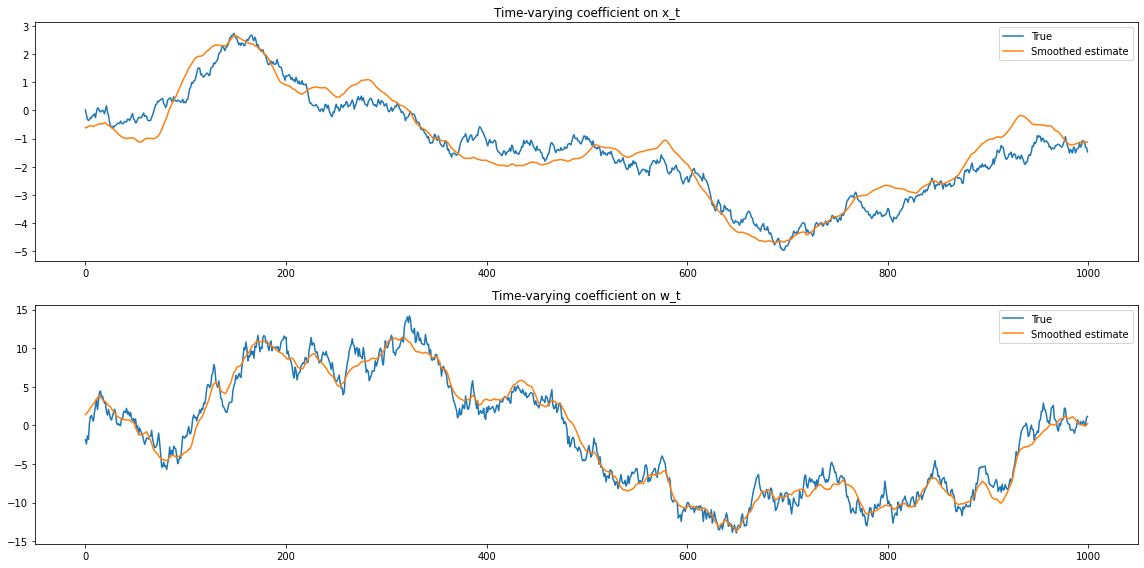

In [165]:
fig, axes = plt.subplots(2, figsize=(16, 8))

ss = pd.DataFrame(res.smoothed_state.T, columns=['x', 'w'])

axes[0].plot(beta_x, label='True')
axes[0].plot(ss['x'], label='Smoothed estimate')
axes[0].set(title='Time-varying coefficient on x_t')
axes[0].legend()

axes[1].plot(beta_w, label='True')
axes[1].plot(ss['w'], label='Smoothed estimate')
axes[1].set(title='Time-varying coefficient on w_t')
axes[1].legend()

fig.tight_layout();

## OLS Trick

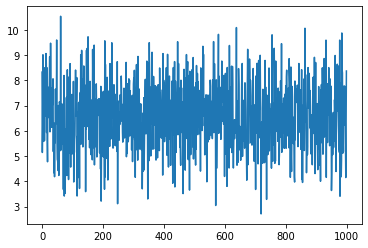

In [245]:
def gen_data_for_model1():
    nobs = 1000

    rs = np.random.RandomState(seed=93572)

    d = 5
    var_y = 1
    var_coeff_x = 1
    var_coeff_w = 1

    x_t = rs.uniform(size=nobs)
    w_t = rs.uniform(size=nobs)
    eps = rs.normal(scale=var_y**0.5, size=nobs)

    beta_x = 0
    beta_w = 3

    y_t = d + beta_x * x_t + beta_w * w_t + eps
    return y_t, x_t, w_t, beta_x, beta_w

y_t, x_t, w_t, beta_x, beta_w = gen_data_for_model1()
_ = plt.plot(y_t)

In [246]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)*0
        self.ssm['transition'] = np.eye(self.k_states)*0
        self.ssm['state_cov'] = np.eye(self.k_states)

        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 2)

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'beta_w_const']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, res.params[2]]
        return params
    
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_intercept', 1, 0] = params[2]

In [247]:

mod = TVRegression(y_t, x_t, w_t)
res = mod.fit(method = 'bfgs', **{'gtol': 1e-10, 'eps': 1e-9})

print(res.summary())

Optimization terminated successfully.
         Current function value: 1.428251
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -1428.251
Date:                Sun, 08 Nov 2020   AIC                           2866.502
Time:                        17:02:40   BIC                           2891.041
Sample:                             0   HQIC                          2875.828
                               - 1000                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        5.0162      0.066 

In [248]:
np.mean(np.square(sm.OLS(y_t,  sm.add_constant(np.c_[x_t, w_t])).fit().resid))

1.018910386638427

In [250]:
sm.OLS(y_t,  sm.add_constant(np.c_[x_t, w_t])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     358.8
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          4.11e-118
Time:                        17:02:47   Log-Likelihood:                -1428.3
No. Observations:                1000   AIC:                             2863.
Df Residuals:                     997   BIC:                             2877.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9803      0.089     55.951      0.000       4.806       5.155
x1             0.0660      0.110      0.599      0.549      -0.150       0.282
x2             3.0091      0.112     26.777      0.000       2.789       3.230
==============================================================================
Omnibus:                        0.173   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.917   Jarque-Bera (JB):                0.254
Skew:                          -0.006   Prob(JB):                        0.881
Kurtosis:                       2.923   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## RV sim

Lambda_t process

0.2653098184250008
2.3392353966588146


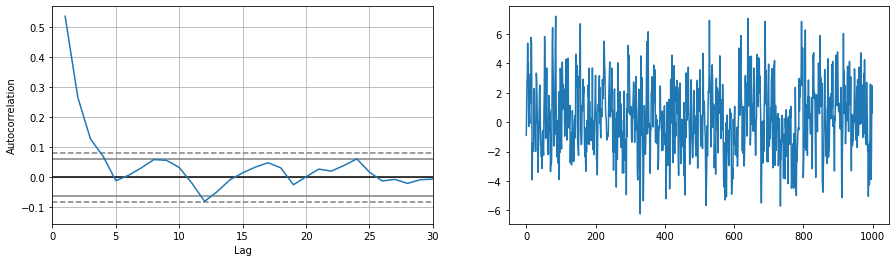

In [274]:
ar = [1, -0.5 ]
ma = [1, ]
n = 1000
lambda_t = arima_process.arma_generate_sample(ar, ma, n, scale = 2)

fig, axs = plt.subplots(figsize = (15,4), ncols = 2)
pd.plotting.autocorrelation_plot(lambda_t, ax = axs[0])
axs[0].set_xlim(0,30)

ax = axs[1]
ax.plot(lambda_t)
print(np.mean(lambda_t))
print(np.std(lambda_t))

In [1099]:
nobs = 1000
var_eps = 0.1
beta_0 = 0.1
beta_1 = -0.2
lambda_ar_1_coeff = -0.5
lambda_scale = 0.3

beta_m = np.array([1, 2, 3])*(-1)
w_scale = 0.1
m = len(beta_m)


def gen_data_for_model(
    nobs, var_eps, beta_0, beta_1, lambda_ar_1_coeff, lambda_scale, beta_m, w_scale, m
):

    burnin = 10
    nobs = nobs + burnin + 1

    lambda_t = arima_process.arma_generate_sample(
        [1, -lambda_ar_1_coeff], [1], nobs, scale=lambda_scale ** 0.5
    )

    eps = np.random.normal(scale=var_eps ** 0.5, size=nobs)
    y_t = np.zeros((nobs))
    w_t = np.random.normal(scale=w_scale, size=(nobs, m))

    for t in range(1, nobs):
        y_t[t] = (y_t[t - 1] * (lambda_t[t] + beta_1)) + beta_0 + (beta_m @ w_t[t]) + eps[t]

    y_t_l1 = y_t[:-1]
    y_t = y_t[1:]

    return (
        y_t[burnin:],
        y_t_l1[burnin:],
        w_t[(burnin + 1):],
        lambda_t[(burnin + 1) :],
    )


y_t, y_t_l1, w_t, lambda_t = gen_data_for_model(
    nobs, var_eps, beta_0, beta_1, lambda_ar_1_coeff, lambda_scale, beta_m, w_scale, m
)

In [1100]:
data_df= pd.DataFrame(np.c_[y_t, y_t_l1, lambda_t], columns = ['y_t', 'y_t_lag', 'lambda_t'])
data_df['test'] = beta_0 + data_df['y_t_lag']*(beta_1 + data_df['lambda_t']) + w_t@beta_m
data_df

,y_t,y_t_lag,lambda_t,test
0,0.503534,0.744934,-0.735938,0.692442
1,0.598962,0.503534,1.082674,0.452104
2,-0.509038,0.598962,-0.760192,-0.523126
3,0.225857,-0.509038,0.326063,0.143555
4,-0.373655,0.225857,0.707628,0.418523
...,...,...,...,...
995,0.781619,-1.101641,0.218560,0.274081
996,-1.308297,0.781619,-0.867410,-0.931484
997,-0.615426,-1.308297,0.864454,-0.404656
998,-0.320161,-0.615426,-0.733397,-0.022167


0.03769402789029074
0.6729057132591046


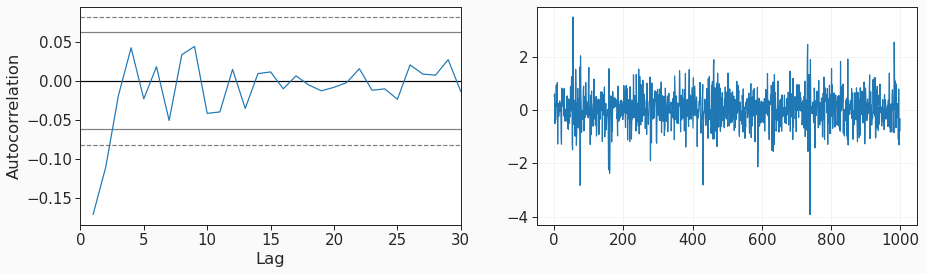

In [1101]:
fig, axs = plt.subplots(figsize = (15,4), ncols = 2)
pd.plotting.autocorrelation_plot(y_t, ax = axs[0])
axs[0].set_xlim(0,30)

ax = axs[1]
ax.plot(y_t)
print(np.mean(y_t))
print(np.std(y_t))

In [1131]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, exog):

        k = np.shape(exog)[1]
        
        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=k,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x k x nobs
        self.ssm['selection'] = np.eye(self.k_states)*0
        self.ssm['selection', 0, 0] = 1
        self.ssm['transition'] = np.eye(self.k_states)*0
        self.ssm['transition', 0, 0] = 1

        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 3)

    @property
    def param_names(self):
        beta_coef_list = ['beta_' + str(i+1) for i in range(self.k_states)]
        param_list = ['intercept', 'var.e', 'var.eta.coeff', 'lambda.phi'] + beta_coef_list
        
        return param_list

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], 1, 1, 0.5, res.params[1:]]
        return params

    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = np.exp(constrained[self.positive_parameters])
        constrained[3] = constrain_stationary_univariate(constrained[3:4])
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = np.log(unconstrained[self.positive_parameters])
        unconstrained[3] = unconstrain_stationary_univariate(constrained[3:4])
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov', 0, 0] = params[2]
        self['transition', 0, 0] = params[3]
        
        for i in range(self.k_states):
            self['state_intercept', i, 0] = params[4+i]

In [1132]:
exog = np.c_[y_t_l1, w_t]
mod = TVRegression(y_t, exog)
res = mod.fit()

print(res.summary())

print(f'''
beta_0: {beta_0:0.5f}
Lambda_t AR: {lambda_ar_1_coeff:0.5f}
Lambda_t Variation: {np.var(lambda_t):0.5f}
beta_1: {(beta_1):0.5f}
''')

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood                -616.264
Date:                Sun, 08 Nov 2020   AIC                           1256.529
Time:                        20:47:28   BIC                           1315.422
Sample:                             0   HQIC                          1278.912
                               - 1000                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0744      0.014      5.471      0.000       0.048       0.101
var.e             0.1139      0.008     13.752      0.000       0.098       0.130
var.eta.coeff     0.2746      0.037     

In [1133]:
sm.OLS(y_t, sm.add_constant(exog)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     136.3
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           6.81e-93
Time:                        20:47:34   Log-Likelihood:                -804.30
No. Observations:                1000   AIC:                             1619.
Df Residuals:                     995   BIC:                             1643.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0586      0.017      3.393      0.001       0.025       0.093
x1            -0.1551      0.026     -6.078      0.000      -0.205      -0.105
x2            -0.6595      0.171     -3.858      0.000      -0.995      -0.324
x3            -1.9888      0.164    -12.150      0.000      -2.310      -1.668
x4            -3.1758      0.175    -18.136      0.000      -3.519      -2.832
==============================================================================
Omnibus:                      155.268   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1274.224
Skew:                          -0.437   Prob(JB):                    2.02e-277
Kurtosis:                       8.460   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

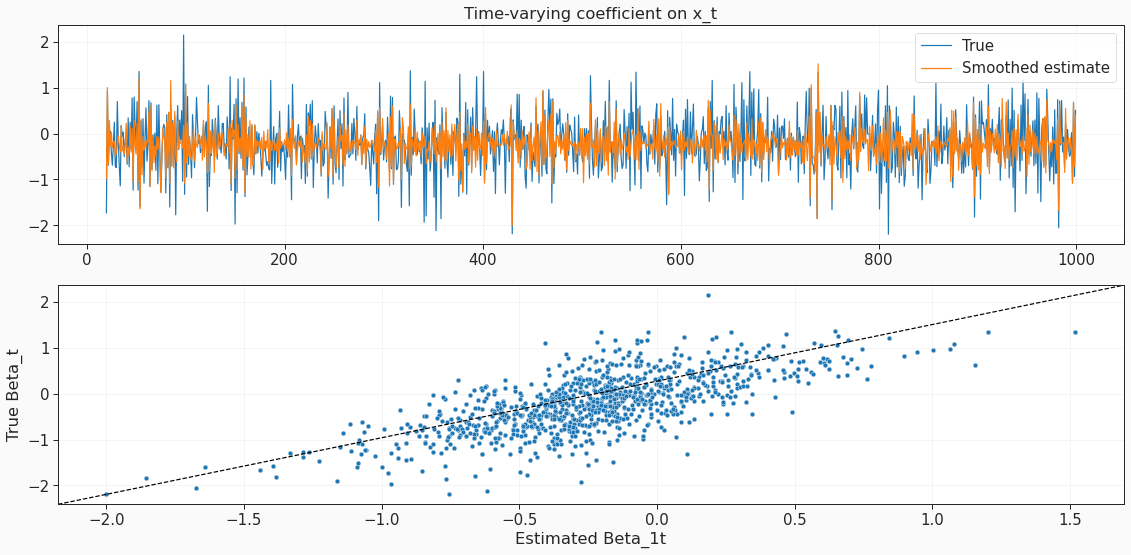

In [1134]:
fig, axes = plt.subplots(nrows = 2, figsize=(16, 8))

ss = pd.DataFrame(res.smoothed_state.T[:,0], columns=['est'])
ss['true'] = lambda_t + beta_1
ss =  ss.iloc[20:,:]

ax = axes[0]
ax.plot(ss['true'], label='True')
ax.plot(ss['est'], label='Smoothed estimate')
ax.set(title='Time-varying coefficient on x_t')
ax.legend()

ax = axes[1]
sns.scatterplot(x = 'est', y = 'true', data = ss)
ax.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', transform=ax.transAxes)
ax.set_xlabel('Estimated Beta_1t')
ax.set_ylabel('True Beta_t')

fig.tight_layout();

## With Actual Data

In [1204]:
data_rv_df = pd.read_feather('../data/temp/data_rv_df.feather')

In [1205]:
# Prep variables
data_rv_df["log_rv"] = np.log(data_rv_df["rv"])
data_rv_df["log_rv_lag_1"] = np.log(data_rv_df["rv_lag_1"])

In [1839]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, exog):

        k = np.shape(exog)[1]
        
        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=k,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x k x nobs
        self.ssm['selection'] = np.eye(self.k_states)*0
        self.ssm['selection', 0, 0] = 1
        self.ssm['transition'] = np.eye(self.k_states)*0
        self.ssm['transition', 0, 0] = 1

        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 3)

    @property
    def param_names(self):
        beta_coef_list = ['beta_' + str(i+1) for i in range(self.k_states)]
        param_list = ['intercept', 'var.e', 'var.eta.coeff', 'lambda.phi'] + beta_coef_list
        
        return param_list

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, .1, 0, res.params[1:]]
        return params

    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = np.exp(constrained[self.positive_parameters])
#         constrained[3] = constrain_stationary_univariate(constrained[3:4])
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = np.log(unconstrained[self.positive_parameters])
#         unconstrained[3] = unconstrain_stationary_univariate(constrained[3:4])
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov', 0, 0] = params[2]
        self['transition', 0, 0] = params[3]
        
        for i in range(self.k_states):
            self['state_intercept', i, 0] = params[4+i]

### Rolling Reg

In [1484]:
# Window length
window = 44

# Regression
reg_formula = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [1485]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

In [1486]:
%%time
# Run HARs
tickers = ["AAPL", "AMZN", "FB", "BAC", "XOM", "T", "INTC", "HD", "KO", "CSCO"]
#data_rv_df["ticker"].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_beta_df = pd.concat(results)


CPU times: user 78.1 ms, sys: 984 ms, total: 1.06 s
Wall time: 2.64 s


<AxesSubplot:xlabel='date'>

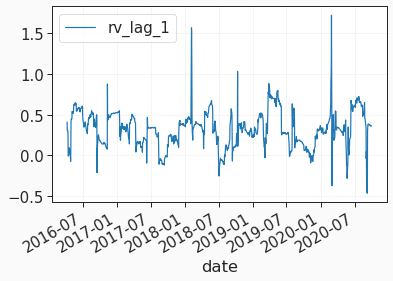

In [1487]:
rolling_beta_df.query('ticker == "AAPL"').plot('date', 'rv_lag_1')

### State Space Model

In [1488]:
ticker_rv_df.columns

Index(['ticker', 'date', 'return', 'rv', 'return_p4', 'return_lag1',
       'return_bp', 'bipower_var_daily', 'bipower_var_tod', 'tod_correction',
       'jump_cut', 'is_jump', 'rs_pos', 'rs_neg', 'sgn_jump_var', 'return_d',
       'return_d_pos', 'return_d_neg', 'return_d_p2', 'return_d_p4',
       'return_d_p2_pos', 'return_d_p4_pos', 'return_d_p2_neg',
       'return_d_p4_neg', 'return_j', 'return_j_pos', 'return_j_neg',
       'return_j_p2', 'return_j_p4', 'return_j_p2_pos', 'return_j_p4_pos',
       'return_j_p2_neg', 'return_j_p4_neg', 'rv_lag_1', 'rv_lag_m5',
       'rv_lag_m22', 'rv_d_1', 'rv_d_5', 'rv_d_22', 'sum_jump_p2_1',
       'sum_jump_p2_5', 'sum_jump_p2_22', 'sum_jump_p2_pos_1',
       'sum_jump_p2_pos_5', 'sum_jump_p2_pos_22', 'sum_jump_p2_neg_1',
       'sum_jump_p2_neg_5', 'sum_jump_p2_neg_22', 'rvol', 'jump_measure_1',
       'sgn_jump_var_lag_1', 'sgn_jump_var_lag_1_pos',
       'sgn_jump_var_lag_1_neg', 'sum_jump_p2_1_lag_1', 'sum_jump_p2_5_lag_1',
       'sum_ju

In [1571]:
def get_HAR_mse(ticker_rv_df):
    return np.mean(np.square(smf.ols('rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22', data = ticker_rv_df).fit().resid))

In [1947]:
# Select data
ticker = "AMZN"
ticker_rv_df = (
    data_rv_df.query("ticker == @ticker").query('year == 2020')
    .sort_values(by="date")
    .reset_index(drop=True)
    .copy()
)

# Select variable names
endog_var = "rv"
exog_var = "rv_lag_1"
interaction_term_coeffs = [
#     "sqrt_rq",
    "sum_jump_p2_1_lag_1",
    "sum_jump_p2_5_lag_1",
    "sum_jump_p2_22_lag_1",
#     "sum_jump_p2_pos_1_lag_1",
#     "sum_jump_p2_neg_1_lag_1",
#     "sum_jump_p2_pos_5_lag_1",
#     "sum_jump_p2_neg_5_lag_1",
#     "sum_jump_p2_pos_22_lag_1",
#     "sum_jump_p2_neg_22_lag_1",
]

control_coeffs = [
#     "rv_lag_m5", "rv_lag_m22"
]

# Set up dataframe with regression vars
reg_data_df = ticker_rv_df[
    ["date"] + [endog_var, exog_var] + control_coeffs + interaction_term_coeffs
]
reg_data_df = reg_data_df.reset_index(drop=True).dropna()
idx_first_non_na = reg_data_df.index[0]

# Construct interaction term arrays
interaction_terms = []
for c in interaction_term_coeffs:
    interaction_terms.append((reg_data_df[c] * reg_data_df[exog_var]).values)
interaction_terms_array = np.array(interaction_terms)

# Construct arrays for the endog and exog variables
endog = reg_data_df[endog_var].values

if len(interaction_terms_array):
    exog = np.c_[
        reg_data_df[[exog_var] + control_coeffs].values, interaction_terms_array.T
    ]
else:
    exog = np.c_[reg_data_df[[exog_var] + control_coeffs].values]

In [1948]:
reg_data_df.head()

,date,rv,rv_lag_1,sum_jump_p2_1_lag_1,sum_jump_p2_5_lag_1,sum_jump_p2_22_lag_1
0,2020-01-02,0.000070,0.000082,0.002371,0.005122,0.001274
1,2020-01-03,0.000076,0.000070,0.000000,0.005122,0.001274
2,2020-01-06,0.000096,0.000076,0.000000,0.005122,0.001274
3,2020-01-07,0.000118,0.000096,0.000000,0.005122,0.001274
4,2020-01-08,0.000087,0.000118,0.000783,0.000631,0.001310


In [1949]:
mod = TVRegression(endog, exog)
res = mod.fit(cov_type = 'robust', method = 'powell', **{'xtol': 1e-5, 'ftol': 1e-5})

print(res.summary())

Optimization terminated successfully.
         Current function value: -6.837117
         Iterations: 10
         Function evaluations: 871
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  189
Model:                   TVRegression   Log Likelihood                1292.215
Date:                Mon, 09 Nov 2020   AIC                          -2560.430
Time:                        00:14:08   BIC                          -2521.529
Sample:                             0   HQIC                         -2544.670
                                - 189                                         
Covariance Type:               robust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       4.25e-05   1.19e-05      3.571      0.000    1.9

In [1950]:
smoothed_state_df = pd.DataFrame(
    res.smoothed_state.T, columns=["alpha_tk"] + control_coeffs + interaction_term_coeffs 
)

smoothed_state_df["date"] = reg_data_df.reset_index(drop=True)["date"]

# Add up components of beta_1t
smoothed_state_df["beta_1t_est"] = smoothed_state_df["alpha_tk"]
for coef in interaction_term_coeffs:
    smoothed_state_df["beta_1t_est"] = smoothed_state_df["beta_1t_est"]  + (
        smoothed_state_df[coef] * reg_data_df.reset_index(drop=True)[coef]
    )

# Merge with rolling estimates
smoothed_state_df = smoothed_state_df.merge(
    rolling_beta_df.query("ticker == @ticker")[["date", exog_var]].rename(
        columns={exog_var: "rolling_beta_1t"}
    ),
    on="date",
)

smoothed_state_df

,alpha_tk,sum_jump_p2_1_lag_1,sum_jump_p2_5_lag_1,sum_jump_p2_22_lag_1,date,beta_1t_est,rolling_beta_1t
0,0.410090,0.000972,0.00210,0.000523,2020-01-02,0.410104,0.453467
1,1.089296,9.177330,-14.98286,-21.607230,2020-01-03,0.985023,0.437920
2,1.034141,9.177330,-14.98286,-21.607230,2020-01-06,0.929868,0.433765
3,1.077317,9.177330,-14.98286,-21.607230,2020-01-07,0.973044,0.424508
4,0.757529,9.177330,-14.98286,-21.607230,2020-01-08,0.726966,0.432905
...,...,...,...,...,...,...,...
184,2.353887,9.177330,-14.98286,-21.607230,2020-09-24,2.326096,0.496122
185,0.263716,9.177330,-14.98286,-21.607230,2020-09-25,0.235925,0.441379
186,0.743808,9.177330,-14.98286,-21.607230,2020-09-28,0.716016,0.459330
187,0.562958,9.177330,-14.98286,-21.607230,2020-09-29,0.539766,0.462845


In [1951]:
temp_df = smoothed_state_df.merge(reg_data_df, on="date")
(
        temp_df["beta_1t_est"]
    )    * temp_df["rv"]

0      0.000029
1      0.000075
2      0.000090
3      0.000115
4      0.000063
         ...   
184    0.002075
185    0.000058
186    0.000134
187    0.000059
188    0.000309
Length: 189, dtype: float64

In [1946]:
temp_df = smoothed_state_df.merge(reg_data_df, on="date")
(
        temp_df["beta_1t_est"]
    )    * temp_df["rv"]

0      0.000023
1      0.000070
2      0.000087
3      0.000110
4      0.000057
         ...   
184    0.002056
185    0.000056
186    0.000125
187    0.000054
188    0.000291
Length: 189, dtype: float64

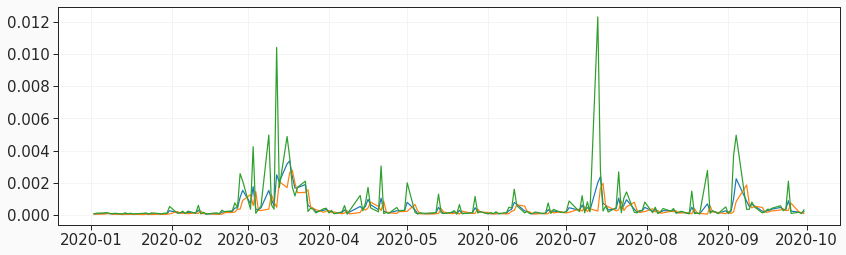

In [1933]:
plt.figure(figsize=(14, 4))
temp_df = smoothed_state_df.merge(reg_data_df, on="date")
param_dict = dict(zip(res.param_names, res.params))

plt.plot(temp_df["date"], temp_df["rv"])
plt.plot(temp_df["date"], sm.OLS(temp_df["rv"], temp_df["rv_lag_1"]).fit().predict())
plt.plot(
    temp_df["date"],
    (
        temp_df["beta_1t_est"]
    )
    * temp_df["rv"]
    + res.params[0],
)

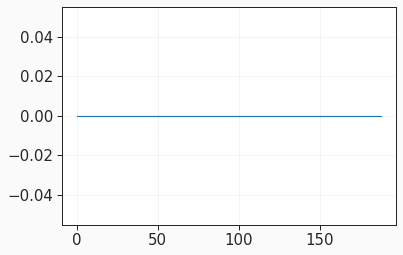

In [1934]:
plt.plot(smoothed_state_df['alpha_tk'] - smoothed_state_df['beta_1t_est'])

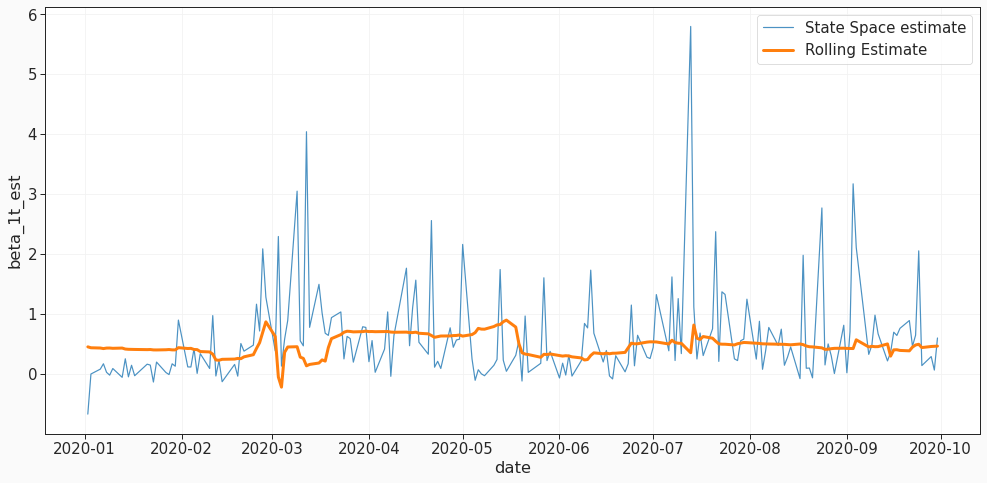

In [1921]:
fig, ax = plt.subplots(nrows=1, figsize=(14, 7))

sns.lineplot(x="date", y="beta_1t_est", label="State Space estimate", alpha=0.8, data=smoothed_state_df, ax=ax)
sns.lineplot(
    x="date",
    y="rolling_beta_1t",
    label="Rolling Estimate",
    lw=3,
    data=smoothed_state_df,
    ax=ax,
)
ax.legend()

# ax.set_ylim(-1, 2)

fig.tight_layout()
# plt.savefig("../exhibits/temp/statespace_sqrtrq.pdf")

In [ ]:
sns.scatterplot(x = 'beta_1t_est', y = 'rolling_beta_1t', data = smoothed_state_df)
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', transform=ax.transAxes)